#Import

In [ ]:
import csv
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from numba import njit

seeds = [42, 1234, 5678, 91011, 31415]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Codigo

In [ ]:


def mutar_sublista(solucion, s):
    n = len(solucion)
    inicio = random.randint(0, n - 1)
    fin = (inicio + s) % n
    solucion = list(solucion)

    if inicio <= fin:
        sublista = solucion[inicio:fin]
        random.shuffle(sublista)
        nueva_solucion = solucion[:inicio] + sublista + solucion[fin:]
    else:
        sublista = solucion[inicio:] + solucion[:fin]
        random.shuffle(sublista)
        nueva_solucion = sublista[-fin:] + solucion[fin:inicio] + sublista[:-fin]

    return np.array(nueva_solucion)
@njit
def barajar_vector(vec):
    n = len(vec)
    for i in range(n - 1, 0, -1):
        j = np.random.randint(0, i + 1)
        temp = vec[i]
        vec[i] = vec[j]
        vec[j] = temp

@njit
def reparar_permutacion_numba(hijo):
    n = len(hijo)
    aparece = np.zeros(n, dtype=np.int32)
    faltantes = np.empty(n, dtype=np.int32)
    num_faltantes = 0

    for i in range(n):
        aparece[hijo[i]] += 1

    for i in range(n):
        if aparece[i] == 0:
            faltantes[num_faltantes] = i
            num_faltantes += 1

    aparece[:] = 0
    idx_faltante = 0
    for i in range(n):
        if aparece[hijo[i]] == 1:
            hijo[i] = faltantes[idx_faltante]
            idx_faltante += 1
        else:
            aparece[hijo[i]] = 1

    return hijo

@njit
def cruce_hux_permutacion_numba(p1, p2):
    n = len(p1)
    hijo1 = np.full(n, -1, dtype=np.int32)
    hijo2 = np.full(n, -1, dtype=np.int32)

    diferentes = np.empty(n, dtype=np.int32)
    num_dif = 0
    for i in range(n):
        if p1[i] != p2[i]:
            diferentes[num_dif] = i
            num_dif += 1

    if num_dif == 0:
        return np.copy(p1.astype(np.int32)), np.copy(p2.astype(np.int32))

    indices_dif = np.empty(num_dif, dtype=np.int32)
    for i in range(num_dif):
        indices_dif[i] = diferentes[i]
    barajar_vector(indices_dif)

    mitad = num_dif // 2
    for i in range(n):
        hijo1[i] = p1[i]
        hijo2[i] = p2[i]

    for i in range(mitad):
        idx = indices_dif[i]
        hijo1[idx] = p2[idx]
        hijo2[idx] = p1[idx]

    hijo1 = reparar_permutacion_numba(hijo1)
    hijo2 = reparar_permutacion_numba(hijo2)

    return hijo1, hijo2

def torneo(poblacion, costes, k=10):
    candidatos = random.sample(range(len(poblacion)), k)
    mejor = min(candidatos, key=lambda i: costes[i])
    return poblacion[mejor]

def cruce_OX(padre1, padre2):
    n = len(padre1)
    p1, p2 = sorted(random.sample(range(n), 2))
    hijo = [-1] * n

    # Copia segmento del primer padre
    hijo[p1:p2] = padre1[p1:p2]

    # Empieza a rellenar desde p2 y recorre cíclicamente
    pos = p2
    for gene in padre2:
        if gene not in hijo:
            while hijo[pos % n] != -1:
                pos += 1
            hijo[pos % n] = gene
            pos += 1

    return np.array(hijo), np.array(hijo.copy())



@njit
def funcionObjetivo(S, A, B):
    coste = 0
    n = len(S)
    for i in range(n):
        for j in range(n):
            coste += A[i, j] * B[S[i], S[j]]
    return coste




def leerFichero(file_path):
    with open(file_path, 'r') as f:
        n = int(f.readline().strip())
        lines = [line.strip() for line in f if line.strip() != '']
        all_numbers = []
        for line in lines:
            all_numbers.extend(map(int, line.split()))

        total_vals = n * n
        A_vals = all_numbers[:total_vals]
        B_vals = all_numbers[total_vals:2 * total_vals]

        A = np.array(A_vals, dtype=np.int64).reshape((n, n))
        B = np.array(B_vals, dtype=np.int64).reshape((n, n))

    return n, A, B
seeds = [42, 1234, 5678, 91011, 31415]


@njit
def distancia_hamming(p1, p2):
    dist = 0
    for i in range(len(p1)):
        if p1[i] != p2[i]:
            dist += 1
    return dist



In [ ]:
with open("/content/drive/MyDrive/Datos/resultados.csv", "w", newline='') as f:
          writer = csv.writer(f)
          writer.writerow(["Algoritmo", "Tamaño", "Seed", "Coste", "Evaluaciones", "Historial"])

#AGS

In [ ]:
def algoritmo_genetico_simple(n, A, B, N=125, generaciones=1000, elitismo=0.1, k=10, tam_mutacion=0.05):
    poblacion = [np.random.permutation(n) for _ in range(N)]
    costes = [funcionObjetivo(ind, A, B) for ind in poblacion]
    mejor_coste = min(costes)
    historial_costes = [mejor_coste]
    total_evaluaciones = N
    elite_size = int(N * elitismo)

    generaciones_sin_mejora = 0

    while True:
        nueva_poblacion = []
        elite_indices = np.argsort(costes)[:elite_size]
        elite = [poblacion[i] for i in elite_indices]
        nueva_poblacion.extend(elite)

        while len(nueva_poblacion) < N:
            padre1 = torneo(poblacion, costes, k)
            padre2 = torneo(poblacion, costes, k)

            if random.random() < 0.9:
                hijo1, hijo2 = cruce_OX(padre1, padre2)
            else:
                s = max(1, int(tam_mutacion * n))
                hijo1 = mutar_sublista(padre1, s)
                hijo2 = mutar_sublista(padre2, s)

            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < N:
                nueva_poblacion.append(hijo2)

        poblacion = nueva_poblacion[:N]
        costes = [funcionObjetivo(ind, A, B) for ind in poblacion]
        total_evaluaciones += N

        nuevo_mejor_coste = min(costes)
        historial_costes.append(nuevo_mejor_coste)

        if nuevo_mejor_coste < mejor_coste:
            mejor_coste = nuevo_mejor_coste
            generaciones_sin_mejora = 0
        else:
            generaciones_sin_mejora += 1

        if generaciones_sin_mejora >= 300:
            break

    mejor_idx = np.argmin(costes)
    return poblacion[mejor_idx], costes[mejor_idx], total_evaluaciones, historial_costes

def ejecutarExperimentoAGS(file_path, seeds):
    n, A, B = leerFichero(file_path)
    best_costs = []
    evs = []
    histories = []
    algoritmo = "GeneticoSimple"

    plt.figure(figsize=(10, 6))

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)

        solucion, coste, evaluaciones, hc = algoritmo_genetico_simple(n, A, B,k=int(n//2.5),tam_mutacion=0.1)
        best_costs.append(coste)
        evs.append(evaluaciones)
        histories.append(hc)

        plt.plot(hc, label=f"Semilla {seed}")
        with open("/content/drive/MyDrive/Datos/resultados.csv", "a", newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                algoritmo,
                n,
                seed,
                coste,
                evaluaciones,
                ','.join(map(str, hc))
            ])
        print(f"Ejecución {seed}: Mejor costo encontrado = {coste}, Evaluaciones = {evaluaciones}")

    media = np.mean(best_costs)
    desviacion = np.std(best_costs)
    mejor_coste = min(best_costs)
    varianza = np.var(best_costs)
    error_relativo = (media - mejor_coste) / mejor_coste * 100
    coef_variacion = desviacion / media * 100

    print("\nResumen del experimento:")
    print(f"Mejor coste: {mejor_coste}")
    print(f"Media: {media:.2f}")
    print(f"Desviación típica: {desviacion:.2f}")
    print(f"Varianza: {varianza:.2f}")
    print(f"Error Relativo (RE): {error_relativo:.2f}%")
    print(f"Coeficiente de Variación (CV): {coef_variacion:.2f}%")

    plt.title("Evolución del coste - AGS")
    plt.xlabel("Iteración")
    plt.ylabel("Costo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_costs, evs, histories

Ejecución 42: Mejor costo encontrado = 463790813, Evaluaciones = 75250
Ejecución 1234: Mejor costo encontrado = 434645824, Evaluaciones = 43750
Ejecución 5678: Mejor costo encontrado = 406880912, Evaluaciones = 60250
Ejecución 91011: Mejor costo encontrado = 460706012, Evaluaciones = 42375
Ejecución 31415: Mejor costo encontrado = 387725564, Evaluaciones = 89750

Resumen del experimento:
Mejor coste: 387725564
Media: 430749825.00
Desviación típica: 29749187.81
Varianza: 885014175640160.75
Error Relativo (RE): 11.10%
Coeficiente de Variación (CV): 6.91%


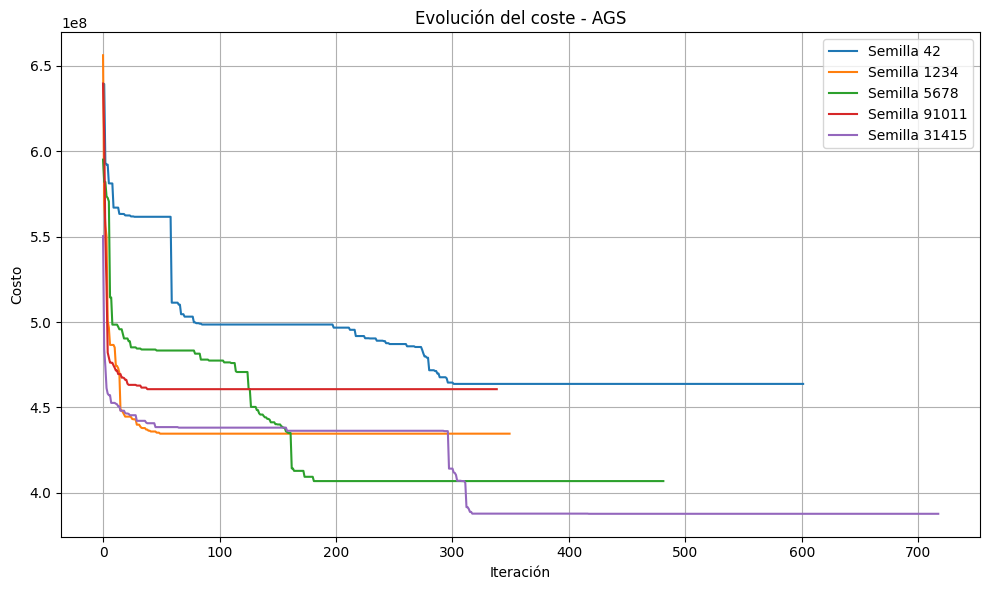

Ejecución 42: Mejor costo encontrado = 124210, Evaluaciones = 152000
Ejecución 1234: Mejor costo encontrado = 124972, Evaluaciones = 162375
Ejecución 5678: Mejor costo encontrado = 125104, Evaluaciones = 257750
Ejecución 91011: Mejor costo encontrado = 125546, Evaluaciones = 165500
Ejecución 31415: Mejor costo encontrado = 125100, Evaluaciones = 323375

Resumen del experimento:
Mejor coste: 124210
Media: 124986.40
Desviación típica: 434.26
Varianza: 188578.24
Error Relativo (RE): 0.63%
Coeficiente de Variación (CV): 0.35%


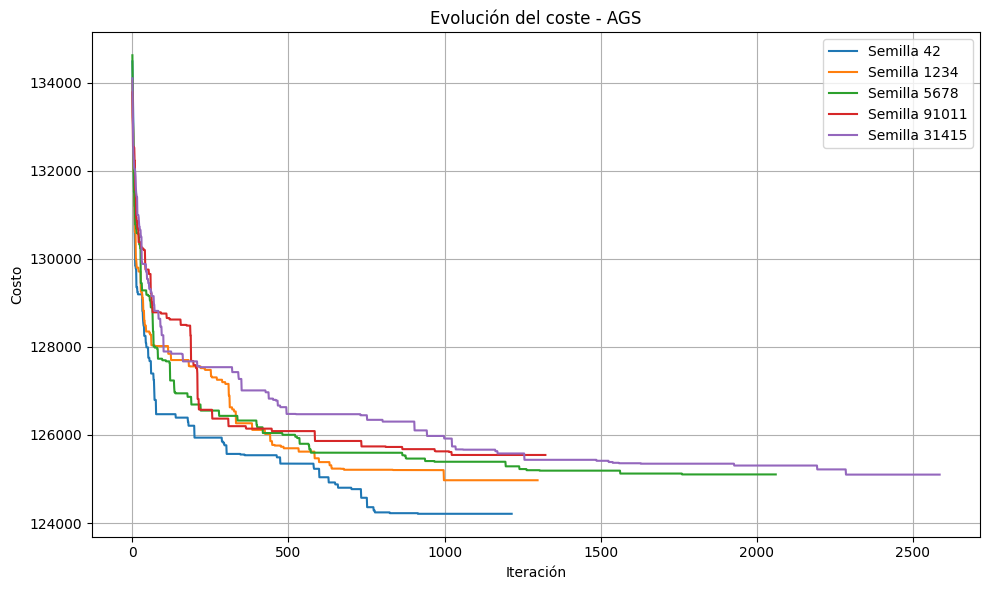

Ejecución 42: Mejor costo encontrado = 559766368, Evaluaciones = 690625
Ejecución 1234: Mejor costo encontrado = 562203418, Evaluaciones = 401875
Ejecución 5678: Mejor costo encontrado = 550206622, Evaluaciones = 529375
Ejecución 91011: Mejor costo encontrado = 561358159, Evaluaciones = 279125
Ejecución 31415: Mejor costo encontrado = 550383808, Evaluaciones = 704500

Resumen del experimento:
Mejor coste: 550206622
Media: 556783675.00
Desviación típica: 5355593.33
Varianza: 28682379873410.40
Error Relativo (RE): 1.20%
Coeficiente de Variación (CV): 0.96%


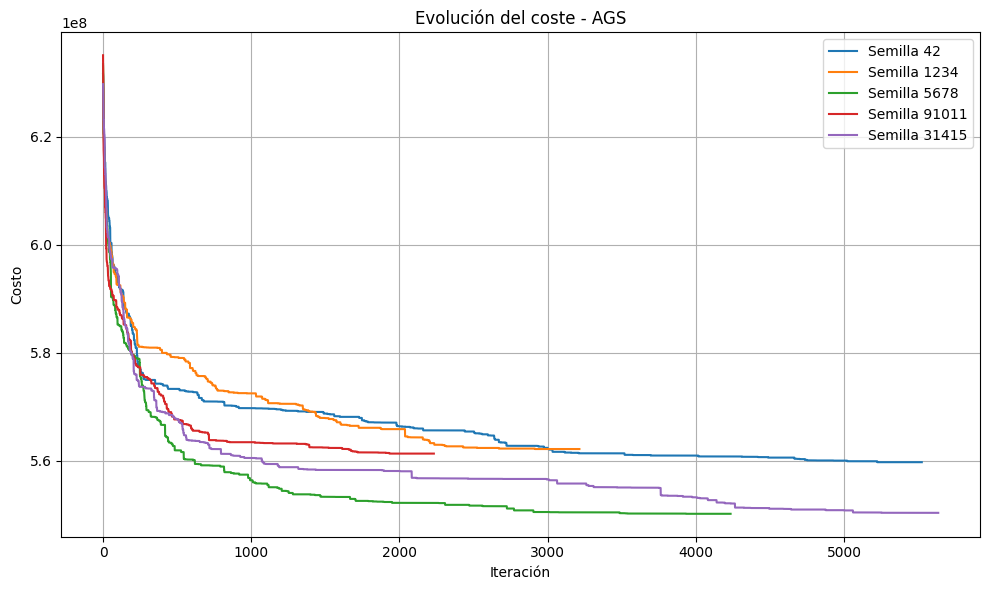

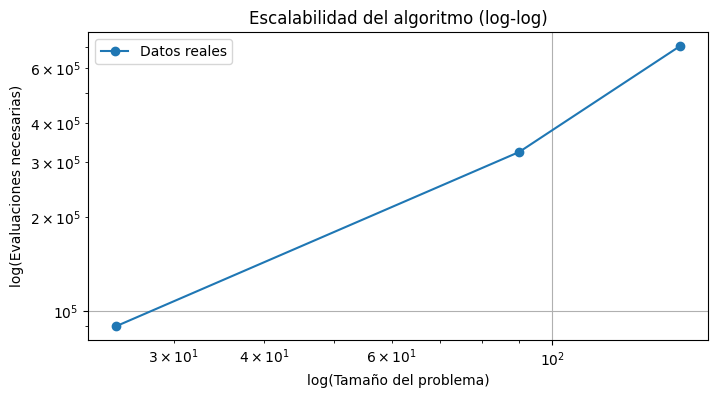

Pendiente (β) = 1.1212
Intercepto (α) = 3.3709


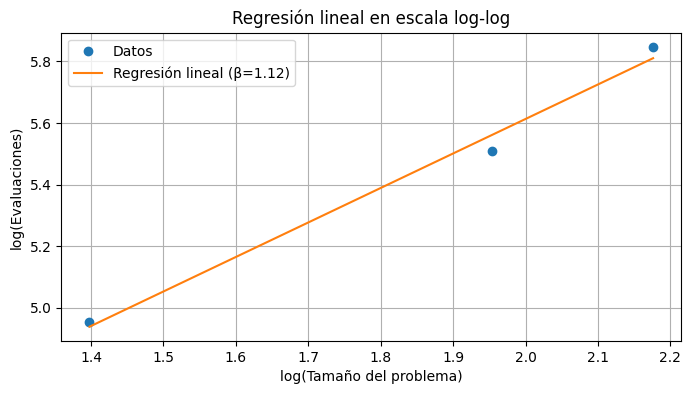

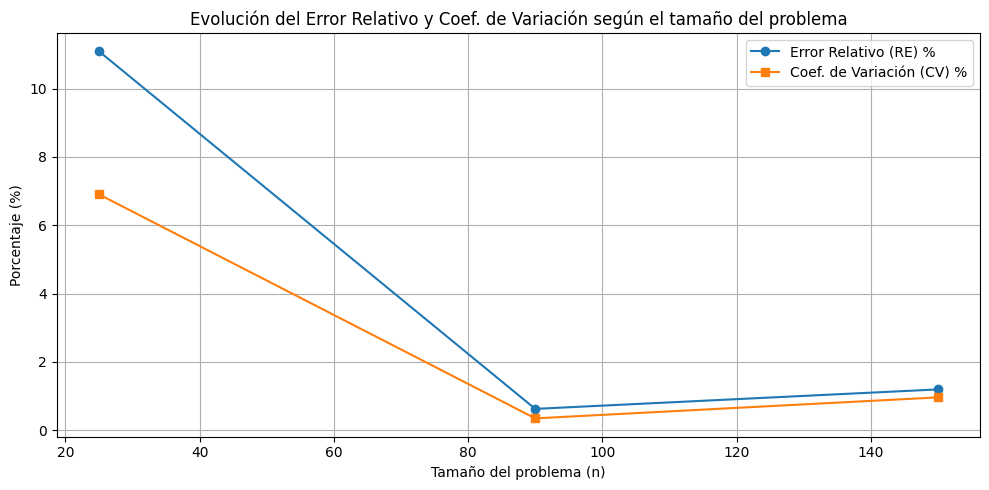

In [ ]:

b1, e1, h1 = ejecutarExperimentoAGS('/content/drive/MyDrive/Datos/tai25b.dat', seeds)
b2, e2, h2 = ejecutarExperimentoAGS('/content/drive/MyDrive/Datos/sko90.dat', seeds)
b3, e3, h3 = ejecutarExperimentoAGS('/content/drive/MyDrive/Datos/tai150b.dat', seeds)
tamaños = np.array([25, 90,150])
# Número de evaluaciones necesarias (ejemplo ficticio)
evaluaciones =[]
evaluaciones.append( max(e1))
evaluaciones.append( max(e2))
evaluaciones.append( max(e3))
# Gráfica log-log
plt.figure(figsize=(8, 4))
plt.loglog(tamaños, evaluaciones, 'o-', label='Datos reales')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones necesarias)')
plt.title('Escalabilidad del algoritmo (log-log)')
plt.grid(True)
plt.legend()
plt.show()

log_sizes = np.log10(tamaños)
log_evals = np.log10(evaluaciones)

# Regresión lineal en escala log-log
slope, intercept = np.polyfit(log_sizes, log_evals, 1)
print(f"Pendiente (β) = {slope:.4f}")
print(f"Intercepto (α) = {intercept:.4f}")

# Para graficar la recta ajustada
x_fit = np.linspace(min(log_sizes), max(log_sizes), 100)
y_fit = slope * x_fit + intercept

# Gráfica log-log
plt.figure(figsize=(8, 4))
plt.plot(log_sizes, log_evals, 'o', label='Datos')
plt.plot(x_fit, y_fit, '-', label=f'Regresión lineal (β={slope:.2f})')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones)')
plt.title('Regresión lineal en escala log-log')
plt.legend()
plt.grid(True)
plt.show()

mejores = np.array([min(b1), min(b2), min(b3)])
medias = np.array([np.mean(b1), np.mean(b2), np.mean(b3)])
stds = np.array([np.std(b1), np.std(b2), np.std(b3)])

# Cálculo de métricas
error_relativo = (medias - mejores) / mejores  # como proporción
cv = stds / medias  # como proporción

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(tamaños, error_relativo * 100, 'o-', label='Error Relativo (RE) %')
plt.plot(tamaños, cv * 100, 's-', label='Coef. de Variación (CV) %')
plt.xlabel('Tamaño del problema (n)')
plt.ylabel('Porcentaje (%)')
plt.title('Evolución del Error Relativo y Coef. de Variación según el tamaño del problema')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#CHC

In [ ]:
def chc(n, A, B, N=70, sin_mejora_max=300):
    poblacion = [np.random.permutation(n) for _ in range(N)]
    costes = [funcionObjetivo(ind, A, B) for ind in poblacion]
    total_evaluaciones = N
    d_threshold = max(n // 4, 1)
    mejor_solucion = poblacion[np.argmin(costes)]
    mejor_coste = min(costes)

    historial_costes = [[min(costes), max(costes), np.mean(costes)]]
    diversidad_por_iteracion = [calcular_diversidad(poblacion)]
    num_reinicios = 0
    generaciones_sin_mejora = 0

    while generaciones_sin_mejora < sin_mejora_max:
        hijos = []
        indices = list(range(N))
        random.shuffle(indices)

        for i in range(0, N - 1, 2):
            padre1 = poblacion[indices[i]]
            padre2 = poblacion[indices[i + 1]]

            if distancia_hamming(padre1, padre2) > d_threshold:
                hijo = cruce_hux_permutacion_numba(padre1, padre2)[0]
                hijos.append(hijo)

        hijos_costes = [funcionObjetivo(h, A, B) for h in hijos]
        total_evaluaciones += len(hijos_costes)

        combinada = list(zip(poblacion, costes)) + list(zip(hijos, hijos_costes))
        combinada.sort(key=lambda x: x[1])
        nueva_poblacion = [ind for ind, _ in combinada[:N]]
        nueva_costes = [coste for _, coste in combinada[:N]]

        # Verificar mejora
        if nueva_costes[0] < mejor_coste:
            mejor_coste = nueva_costes[0]
            mejor_solucion = nueva_poblacion[0]
            generaciones_sin_mejora = 0
        else:
            generaciones_sin_mejora += 1

        # Verificar si la población no ha cambiado
        poblacion_igual = all(np.array_equal(p1, p2) for p1, p2 in zip(poblacion, nueva_poblacion))

        if poblacion_igual:
            if d_threshold > 1:
                d_threshold -= 1
            else:
                # Reinicio poblacional
                poblacion = [mejor_solucion] + [np.random.permutation(n) for _ in range(N - 1)]
                costes = [funcionObjetivo(ind, A, B) for ind in poblacion]
                total_evaluaciones += N
                d_threshold = max(n // 4, 1)
                num_reinicios += 1
                generaciones_sin_mejora = 0

                historial_costes.append([min(costes), max(costes), np.mean(costes)])
                diversidad_por_iteracion.append(calcular_diversidad(poblacion))
                continue

        poblacion = nueva_poblacion
        costes = nueva_costes

        historial_costes.append([min(costes), max(costes), np.mean(costes)])
        diversidad_por_iteracion.append(calcular_diversidad(poblacion))

    return mejor_solucion, mejor_coste, total_evaluaciones, historial_costes, diversidad_por_iteracion, num_reinicios
def calcular_diversidad(poblacion):
    n = len(poblacion[0])
    total = 0
    count = 0
    for i in range(len(poblacion)):
        for j in range(i + 1, len(poblacion)):
            dist = distancia_hamming(poblacion[i], poblacion[j])
            total += dist
            count += 1
    return total / (count * n) if count > 0 else 0  # Normalizada entre 0 y 1

def ejecutarExperimentoCHC(file_path, seeds):
    n, A, B = leerFichero(file_path)
    best_costs = []
    evs = []
    histories = []
    diversidades = []
    algoritmo = "CHC"

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)

        solucion, coste, evaluaciones, hc, diversidad,nr = chc(n, A, B)
        print(nr)
        best_costs.append(coste)
        evs.append(evaluaciones)
        histories.append(hc)
        diversidades.append(diversidad)
        # Separar los tres vectores (cada uno de longitud igual al número de generaciones)
        minimos  = [h[0] for h in hc]
        maximos  = [h[1] for h in hc]
        medias   = [h[2] for h in hc]
        # Gráfica individual del coste
        plt.figure(figsize=(8, 4))
        plt.plot(minimos, label="Costo mínimo")
        plt.plot(maximos, label="Costo máximo")
        plt.plot(medias, label="Costo medio")

        plt.title(f"Evolución del costo - Semilla {seed}")
        plt.xlabel("Iteración")
        plt.ylabel("Costo")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Gráfica individual de diversidad genética normalizada
        plt.figure(figsize=(8, 4))
        plt.plot(diversidad, label="Diversidad genética (normalizada)")
        plt.title(f"Diversidad genética - Semilla {seed}")
        plt.xlabel("Generación")
        plt.ylabel("Diversidad (0 a 1)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Guardar resultados en CSV
        with open("/content/drive/MyDrive/Datos/resultados.csv", "a", newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                algoritmo,
                n,
                seed,
                coste,
                evaluaciones,
                ','.join(map(str, hc)),
                ','.join(map(str, diversidad))
            ])

        print(f"Ejecución {seed}: Mejor costo encontrado = {coste}, Evaluaciones = {evaluaciones}")

    # Estadísticas resumen
    media = np.mean(best_costs)
    desviacion = np.std(best_costs)
    mejor_coste = min(best_costs)
    varianza = np.var(best_costs)
    error_relativo = (media - mejor_coste) / mejor_coste * 100
    coef_variacion = desviacion / media * 100

    print("\nResumen del experimento:")
    print(f"Mejor coste: {mejor_coste}")
    print(f"Media: {media:.2f}")
    print(f"Desviación típica: {desviacion:.2f}")
    print(f"Varianza: {varianza:.2f}")
    print(f"Error Relativo (RE): {error_relativo:.2f}%")
    print(f"Coeficiente de Variación (CV): {coef_variacion:.2f}%")

    return best_costs, evs, histories

87


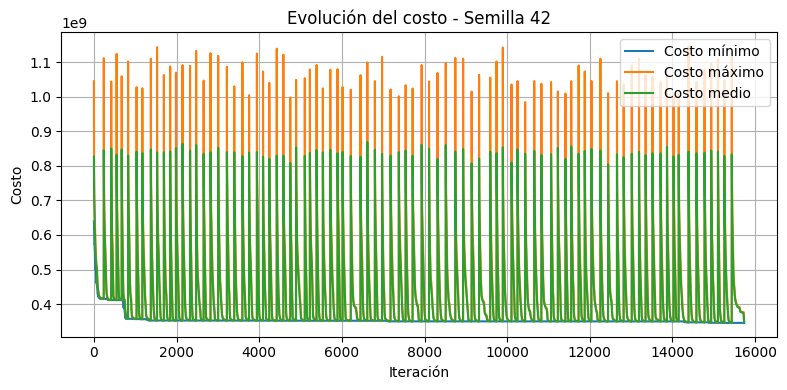

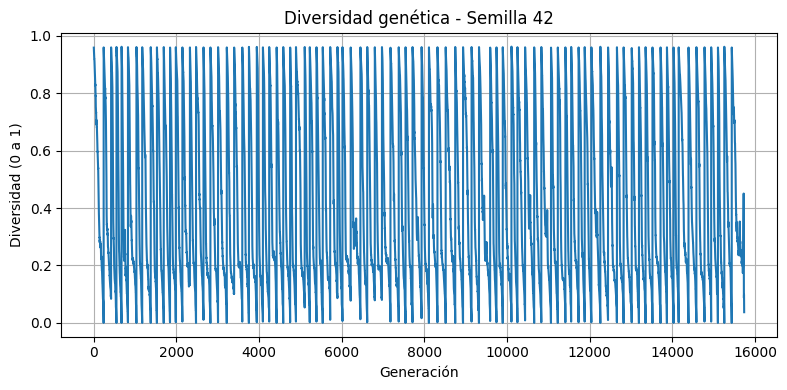

Ejecución 42: Mejor costo encontrado = 345530010, Evaluaciones = 350522
230


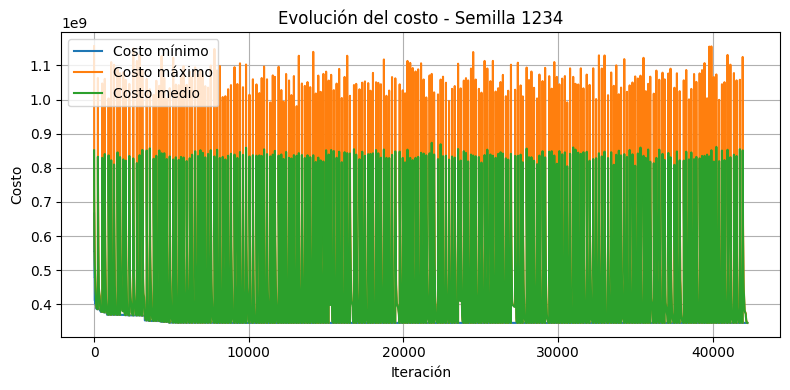

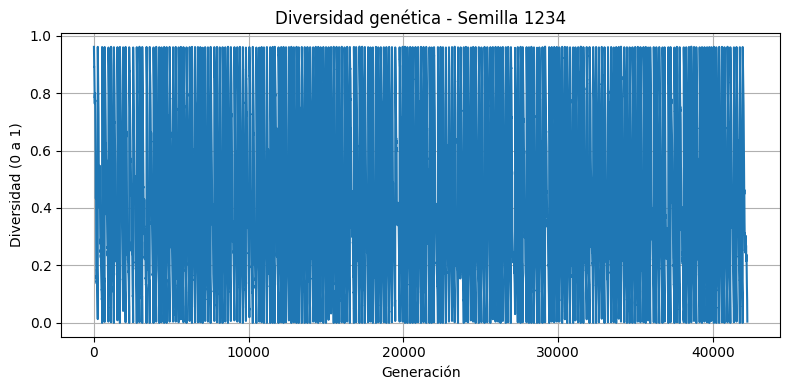

Ejecución 1234: Mejor costo encontrado = 345415156, Evaluaciones = 954676
80


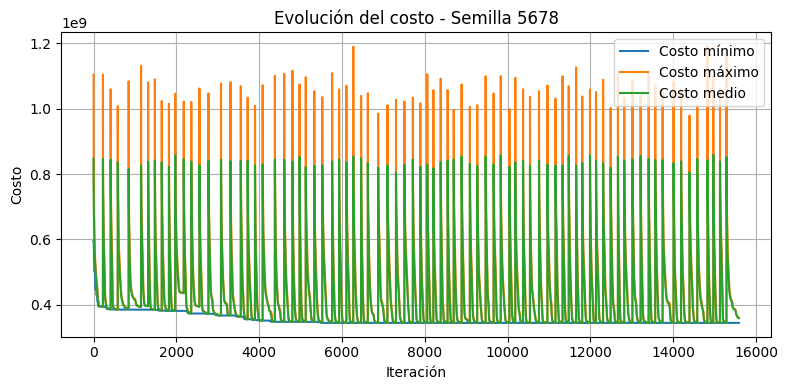

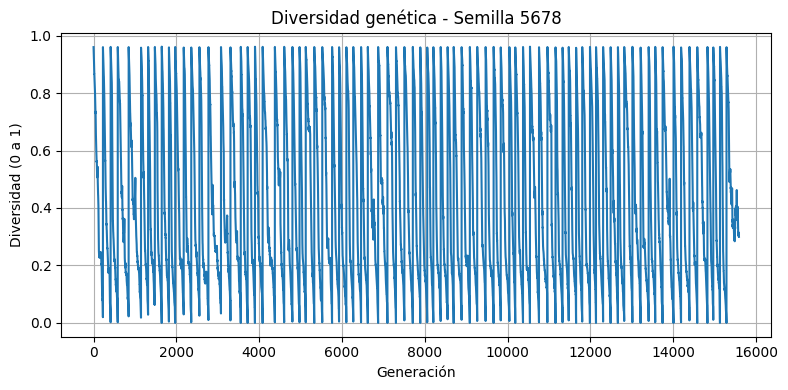

Ejecución 5678: Mejor costo encontrado = 344355646, Evaluaciones = 357907
157


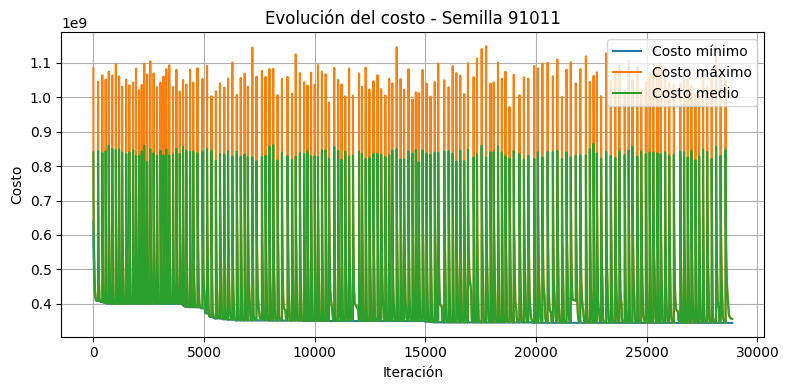

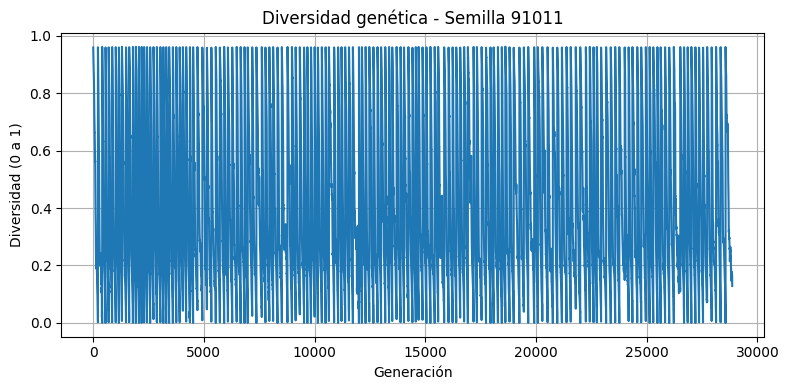

Ejecución 91011: Mejor costo encontrado = 344355646, Evaluaciones = 652910
41


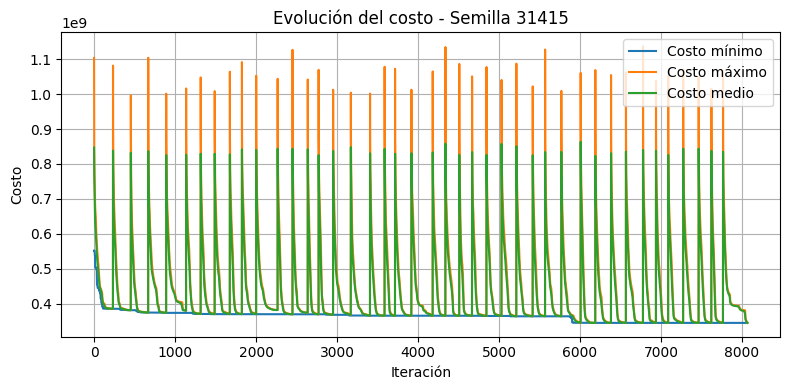

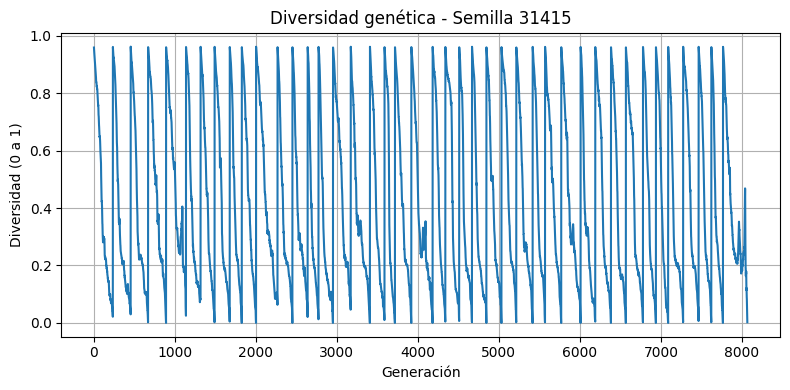

Ejecución 31415: Mejor costo encontrado = 344994713, Evaluaciones = 184505

Resumen del experimento:
Mejor coste: 344355646
Media: 344930234.20
Desviación típica: 501864.70
Varianza: 251868175437.76
Error Relativo (RE): 0.17%
Coeficiente de Variación (CV): 0.15%
2


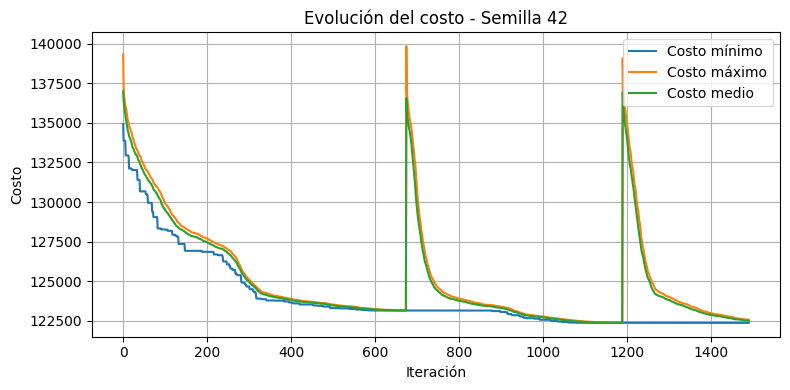

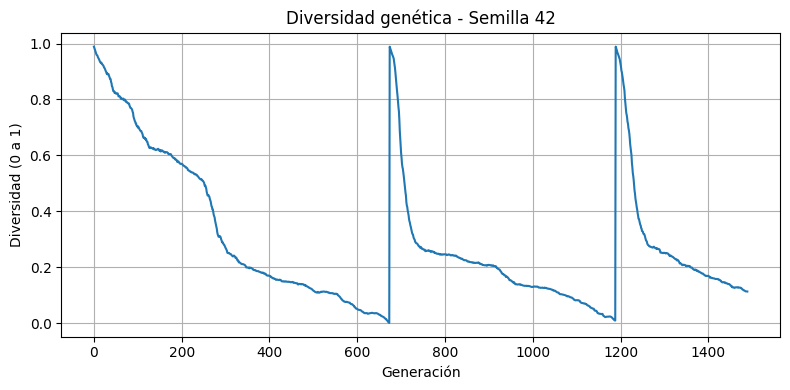

Ejecución 42: Mejor costo encontrado = 122376, Evaluaciones = 35235
3


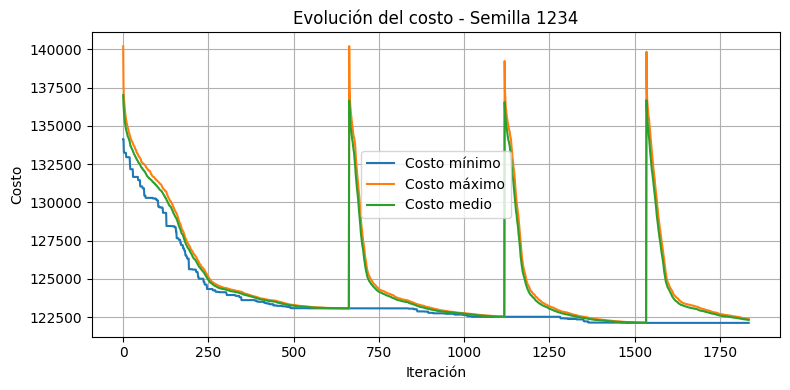

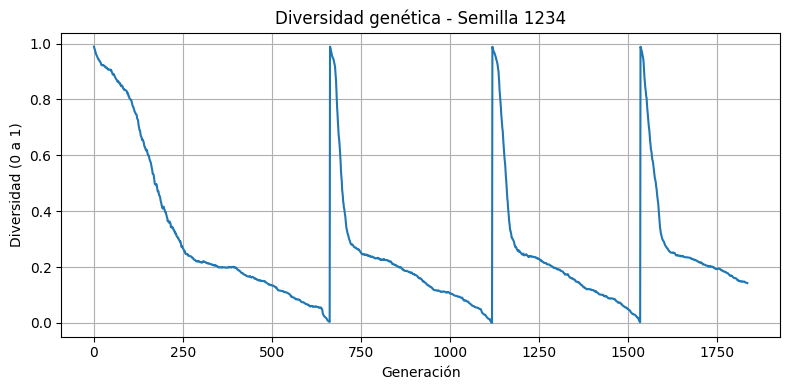

Ejecución 1234: Mejor costo encontrado = 122122, Evaluaciones = 36102
5


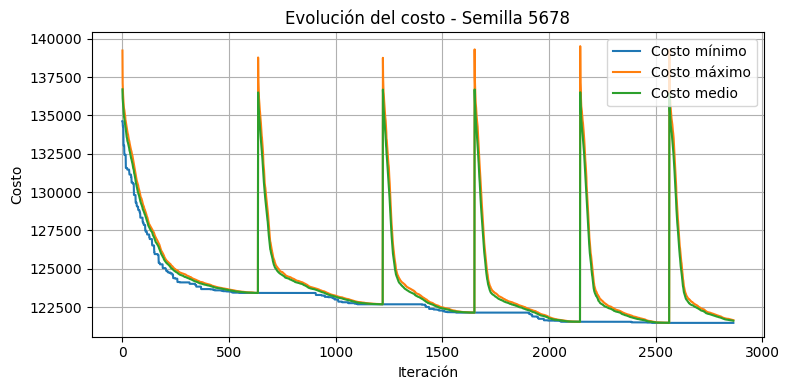

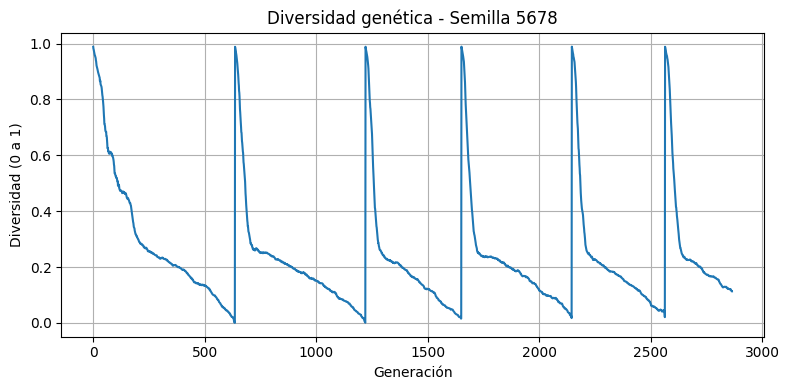

Ejecución 5678: Mejor costo encontrado = 121470, Evaluaciones = 55093
10


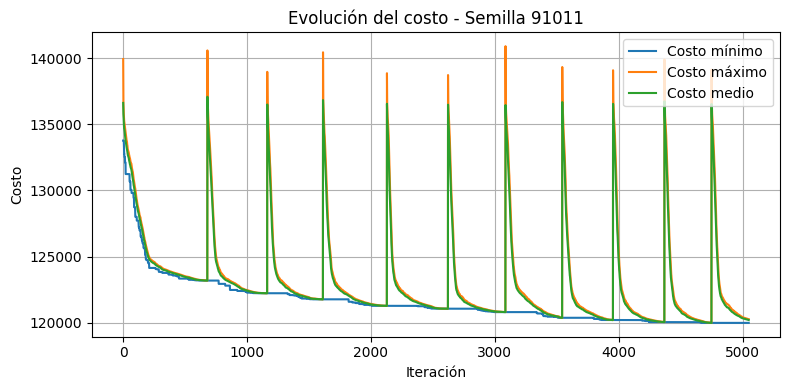

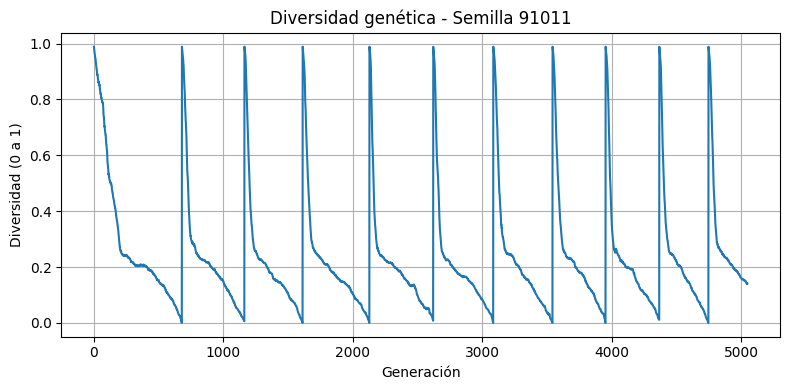

Ejecución 91011: Mejor costo encontrado = 119974, Evaluaciones = 88068
6


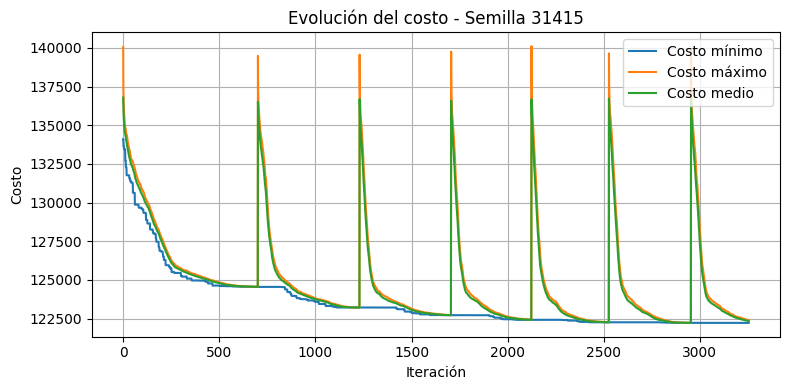

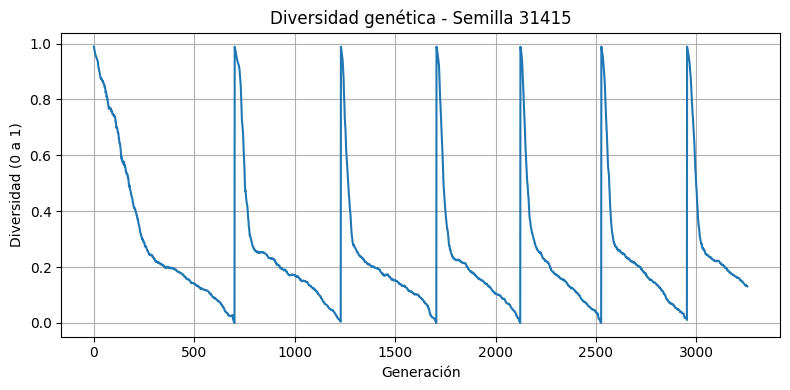

Ejecución 31415: Mejor costo encontrado = 122224, Evaluaciones = 62038

Resumen del experimento:
Mejor coste: 119974
Media: 121633.20
Desviación típica: 885.36
Varianza: 783860.16
Error Relativo (RE): 1.38%
Coeficiente de Variación (CV): 0.73%
3


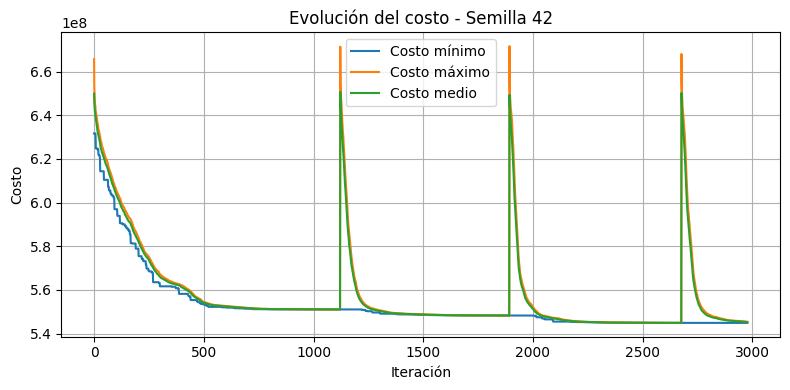

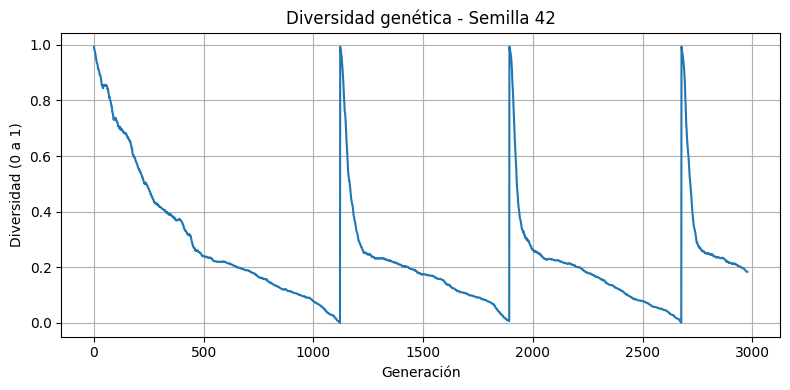

Ejecución 42: Mejor costo encontrado = 544947763, Evaluaciones = 54897
2


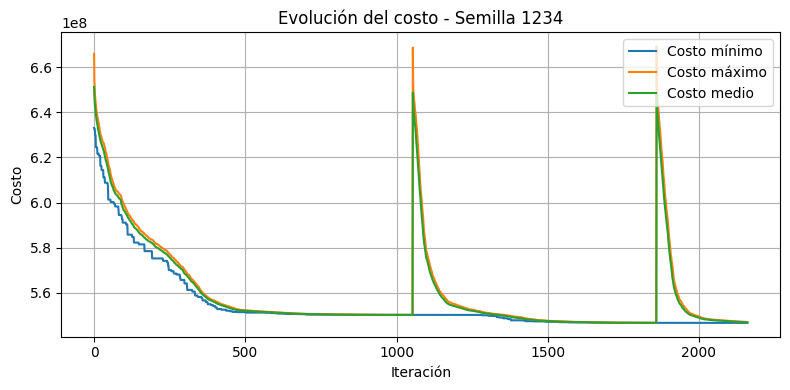

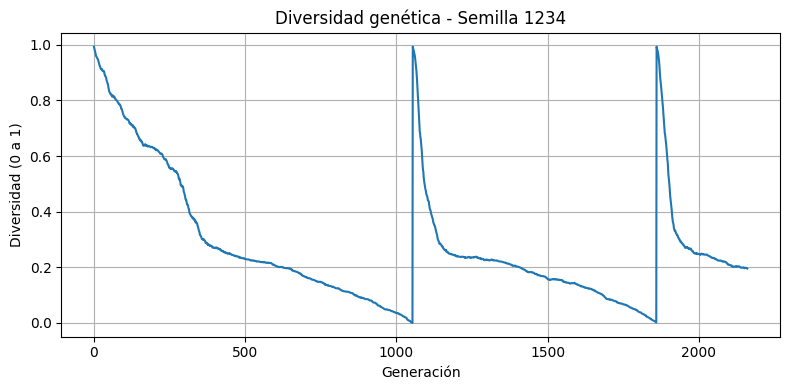

Ejecución 1234: Mejor costo encontrado = 546729685, Evaluaciones = 40900
6


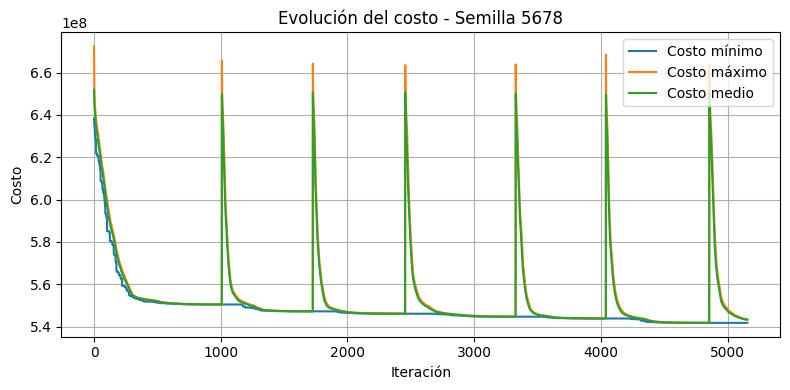

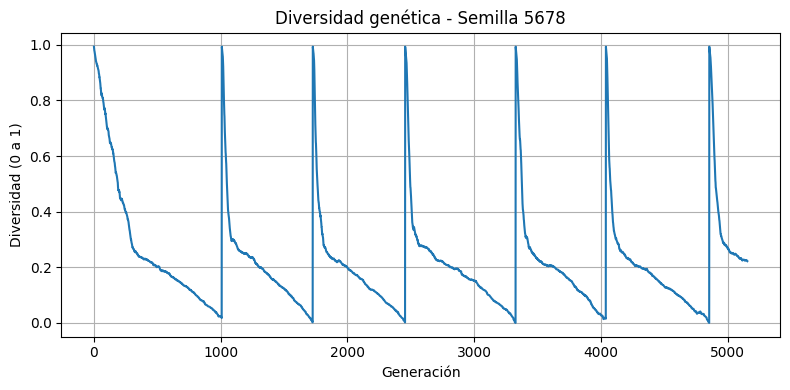

Ejecución 5678: Mejor costo encontrado = 541787369, Evaluaciones = 84943
7


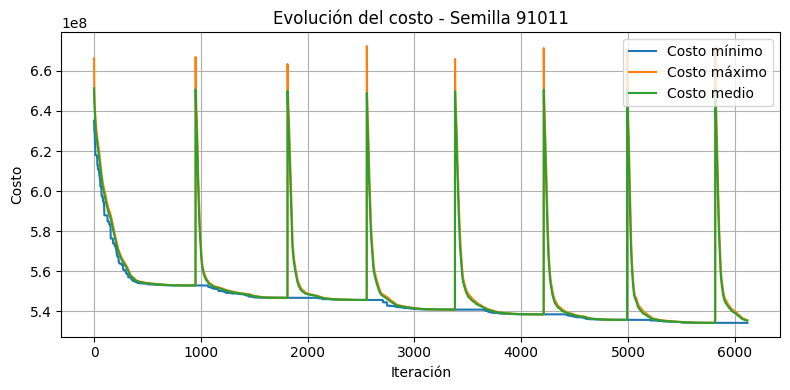

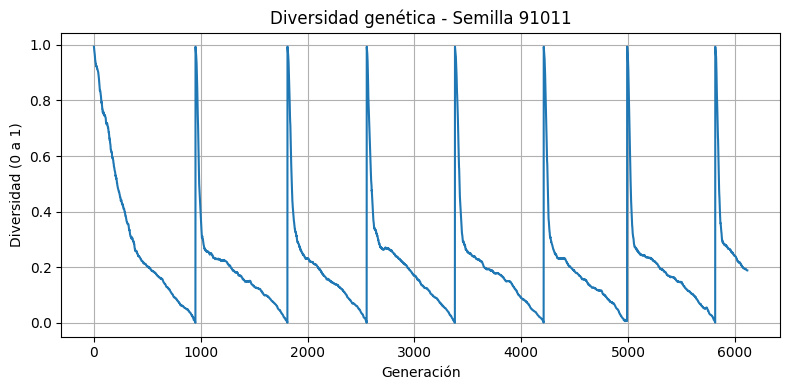

Ejecución 91011: Mejor costo encontrado = 534293838, Evaluaciones = 106414
5


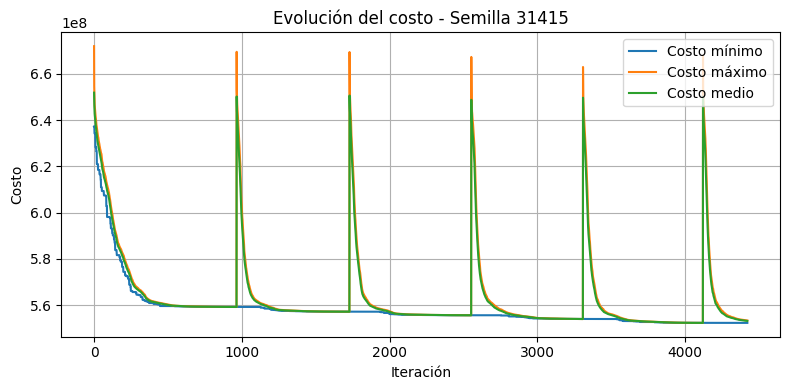

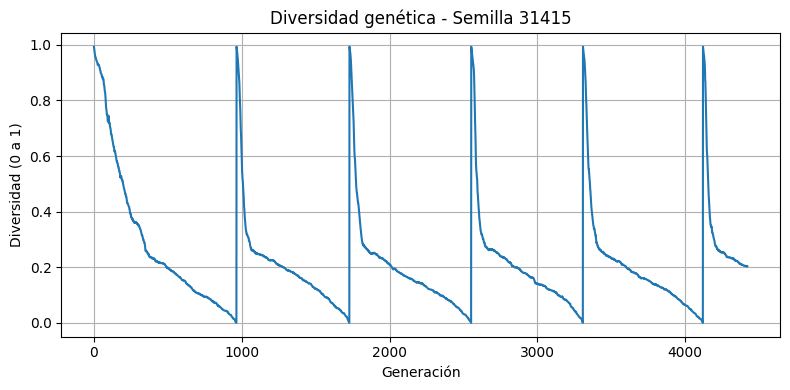

Ejecución 31415: Mejor costo encontrado = 552356794, Evaluaciones = 80054

Resumen del experimento:
Mejor coste: 534293838
Media: 544023089.80
Desviación típica: 5954629.99
Varianza: 35457618375982.96
Error Relativo (RE): 1.82%
Coeficiente de Variación (CV): 1.09%


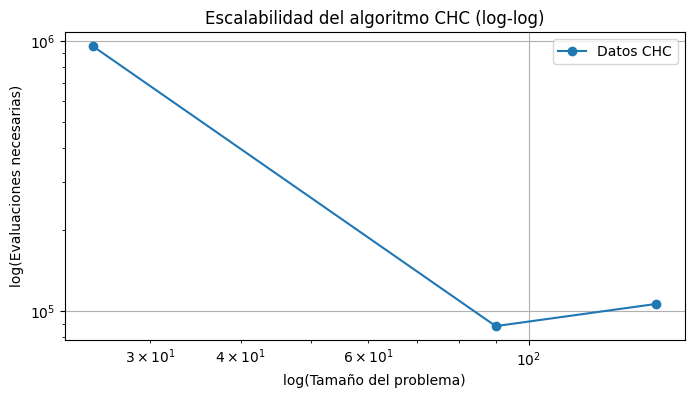

Pendiente (β) = -1.3472
Intercepto (α) = 7.7999


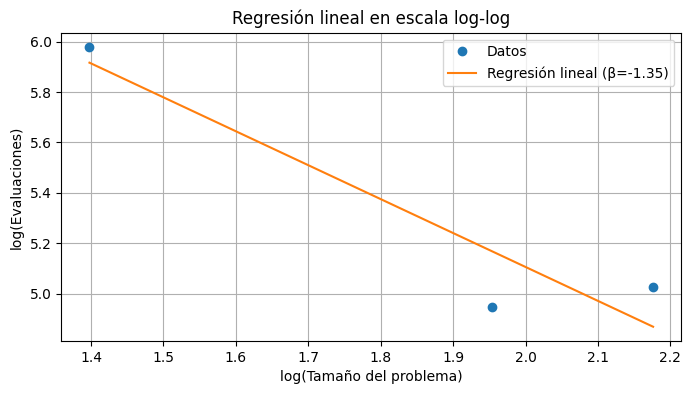

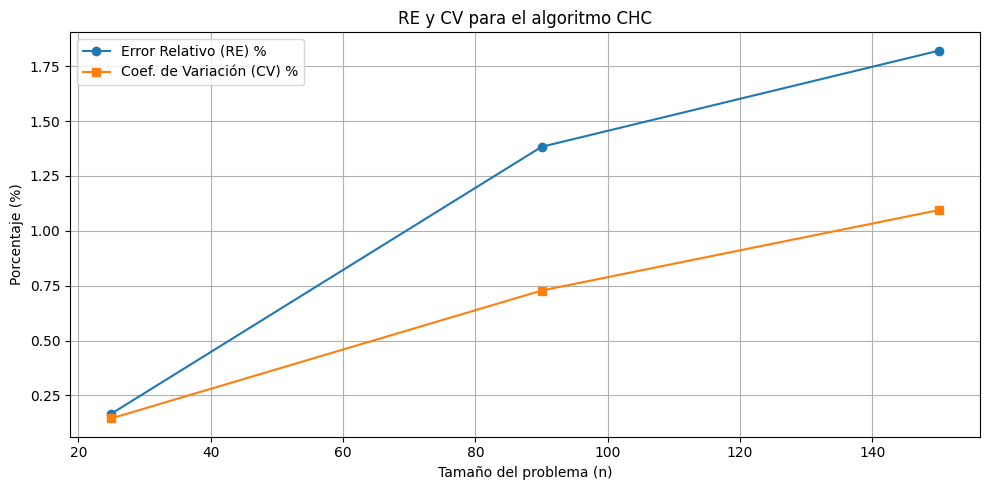

In [ ]:
# Ejecutar el CHC con tres datasets
b1, e1, h1 = ejecutarExperimentoCHC('/content/drive/MyDrive/Datos/tai25b.dat', seeds)
b2, e2, h2 = ejecutarExperimentoCHC('/content/drive/MyDrive/Datos/sko90.dat', seeds)
b3, e3, h3 = ejecutarExperimentoCHC('/content/drive/MyDrive/Datos/tai150b.dat', seeds)

tamaños = np.array([25, 90, 150])
evaluaciones = [max(e1), max(e2), max(e3)]

# Gráfica log-log de escalabilidad
plt.figure(figsize=(8, 4))
plt.loglog(tamaños, evaluaciones, 'o-', label='Datos CHC')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones necesarias)')
plt.title('Escalabilidad del algoritmo CHC (log-log)')
plt.grid(True)
plt.legend()
plt.show()

# Regresión log-log
log_sizes = np.log10(tamaños)
log_evals = np.log10(evaluaciones)
slope, intercept = np.polyfit(log_sizes, log_evals, 1)
print(f"Pendiente (β) = {slope:.4f}")
print(f"Intercepto (α) = {intercept:.4f}")

# Línea ajustada
x_fit = np.linspace(min(log_sizes), max(log_sizes), 100)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(8, 4))
plt.plot(log_sizes, log_evals, 'o', label='Datos')
plt.plot(x_fit, y_fit, '-', label=f'Regresión lineal (β={slope:.2f})')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones)')
plt.title('Regresión lineal en escala log-log')
plt.legend()
plt.grid(True)
plt.show()

# Métricas de calidad
mejores = np.array([min(b1), min(b2), min(b3)])
medias = np.array([np.mean(b1), np.mean(b2), np.mean(b3)])
stds = np.array([np.std(b1), np.std(b2), np.std(b3)])

error_relativo = (medias - mejores) / mejores
cv = stds / medias

# Gráfico de calidad
plt.figure(figsize=(10, 5))
plt.plot(tamaños, error_relativo * 100, 'o-', label='Error Relativo (RE) %')
plt.plot(tamaños, cv * 100, 's-', label='Coef. de Variación (CV) %')
plt.xlabel('Tamaño del problema (n)')
plt.ylabel('Porcentaje (%)')
plt.title('RE y CV para el algoritmo CHC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#AGM

In [ ]:

def clearing(poblacion, costes, radio, miembros_nicho):
    N = len(poblacion)
    indices_ordenados = np.argsort(costes)  # orden ascendente (mejor primero)
    aptitudes = np.array(costes, dtype=float, copy=True)

    asignados = np.zeros(N, dtype=bool)

    for i in indices_ordenados:
        if asignados[i]:
            continue
        count = 1  # el mejor del nicho se queda
        for j in indices_ordenados:
            if i == j or asignados[j]:
                continue
            dist = distancia_hamming(poblacion[i], poblacion[j])
            if dist < radio:
              if count < miembros_nicho:
                count += 1
                asignados[j] = True  # Aceptado en nicho
              else:
                aptitudes[j] = np.inf
                asignados[j] = True


    # filtrar los individuos con aptitud válida
    nueva_poblacion = [ind for ind, apt in zip(poblacion, aptitudes) if apt < np.inf]

    return nueva_poblacion

def ag_multimodal(n, A, B, N=70, max_sin_mejora=300, elitismo=0.1, k=10, tam_mutacion=0.05, miembrosNicho=2):
    poblacion = [np.random.permutation(n) for _ in range(N)]
    costes = [funcionObjetivo(ind, A, B) for ind in poblacion]
    historial_costes = [min(costes)]
    historial_clearing = []
    total_evaluaciones = N
    elite_size = int(N * elitismo)

    mejor_coste = min(costes)
    sin_mejora = 0

    while sin_mejora < max_sin_mejora:
        nueva_poblacion = []
        elite_indices = np.argsort(costes)[:elite_size]
        elite = [poblacion[i] for i in elite_indices]
        nueva_poblacion.extend(elite)

        while len(nueva_poblacion) < N:
            padre1 = torneo(poblacion, costes, k)
            padre2 = torneo(poblacion, costes, k)

            if random.random() < 0.9:
                hijo1, hijo2 = cruce_OX(padre1, padre2)
            else:
                s = max(1, int(tam_mutacion * n))
                hijo1 = mutar_sublista(padre1, s)
                hijo2 = mutar_sublista(padre2, s)

            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < N:
                nueva_poblacion.append(hijo2)

        costes_clearing = [funcionObjetivo(ind, A, B) for ind in nueva_poblacion]
        nueva_poblacion = clearing(nueva_poblacion, costes_clearing, n //8, miembrosNicho)
        total_evaluaciones += len(nueva_poblacion)
        historial_clearing.append(len(nueva_poblacion))

        while len(nueva_poblacion) < N:
            padre1 = torneo(poblacion, costes, k)
            padre2 = torneo(poblacion, costes, k)

            if random.random() < 0.9:
                hijo1, hijo2 = cruce_OX(padre1, padre2)
            else:
                s = max(1, int(tam_mutacion * n))
                hijo1 = mutar_sublista(padre1, s)
                hijo2 = mutar_sublista(padre2, s)

            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < N:
                nueva_poblacion.append(hijo2)

        poblacion = nueva_poblacion[:N]
        costes = [funcionObjetivo(ind, A, B) for ind in poblacion]
        total_evaluaciones += N
        costo_actual = min(costes)
        historial_costes.append(costo_actual)

        if costo_actual < mejor_coste:
            mejor_coste = costo_actual
            sin_mejora = 0
        else:
            sin_mejora += 1

    mejor_idx = np.argmin(costes)
    return poblacion[mejor_idx], costes[mejor_idx], total_evaluaciones, historial_costes, historial_clearing

def ejecutarExperimentoMultimodal(file_path, seeds):
    n, A, B = leerFichero(file_path)
    best_costs = []
    evs = []
    histories = []
    hclears = []

    algoritmo = "GeneticoMultimodal"

    plt.figure(figsize=(10, 6))  # Gráfica de coste

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)

        solucion, coste, evaluaciones, hc, hclear = ag_multimodal(n, A, B)
        best_costs.append(coste)
        evs.append(evaluaciones)
        histories.append(hc)
        hclears.append(hclear)

        plt.plot(hc, label=f"Semilla {seed}")
        with open("/content/drive/MyDrive/Datos/resultados.csv", "a", newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                algoritmo,
                n,
                seed,
                coste,
                evaluaciones,
                ','.join(map(str, hc))
            ])
        print(f"Ejecución {seed}: Mejor costo encontrado = {coste}, Evaluaciones = {evaluaciones}")

    # Métricas resumen
    media = np.mean(best_costs)
    desviacion = np.std(best_costs)
    mejor_coste = min(best_costs)
    varianza = np.var(best_costs)
    error_relativo = (media - mejor_coste) / mejor_coste * 100
    coef_variacion = desviacion / media * 100

    print("\nResumen del experimento:")
    print(f"Mejor coste: {mejor_coste}")
    print(f"Media: {media:.2f}")
    print(f"Desviación típica: {desviacion:.2f}")
    print(f"Varianza: {varianza:.2f}")
    print(f"Error Relativo (RE): {error_relativo:.2f}%")
    print(f"Coeficiente de Variación (CV): {coef_variacion:.2f}%")

    plt.title("Evolución del coste - Multimodal")
    plt.xlabel("Iteración")
    plt.ylabel("Costo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Gráfica de hclear por semilla
    plt.figure(figsize=(10, 6))
    for hclear, seed in zip(hclears, seeds):
        plt.plot(hclear, label=f"Semilla {seed}")
    plt.title("Evolución del tamaño tras Clearing por semilla")
    plt.xlabel("Iteración donde se aplica Clearing")
    plt.ylabel("Tamaño de la población tras Clearing")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_costs, evs, histories

Ejecución 42: Mejor costo encontrado = 362793203, Evaluaciones = 158518
Ejecución 1234: Mejor costo encontrado = 409039685, Evaluaciones = 117720
Ejecución 5678: Mejor costo encontrado = 444855452, Evaluaciones = 241127
Ejecución 91011: Mejor costo encontrado = 427032645, Evaluaciones = 120030
Ejecución 31415: Mejor costo encontrado = 439456531, Evaluaciones = 84434

Resumen del experimento:
Mejor coste: 362793203
Media: 416635503.20
Desviación típica: 29603902.18
Varianza: 876391024537334.62
Error Relativo (RE): 14.84%
Coeficiente de Variación (CV): 7.11%


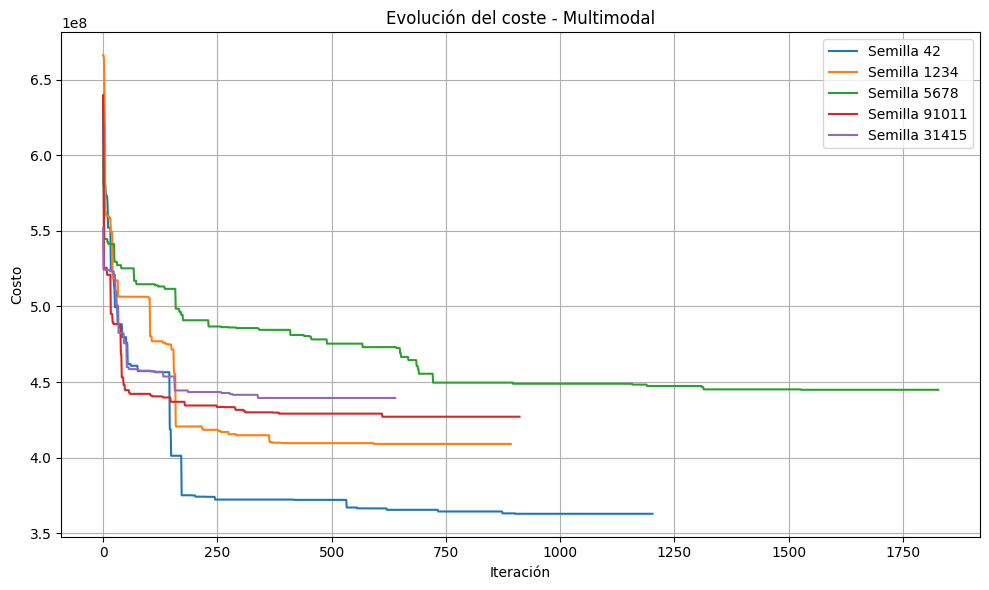

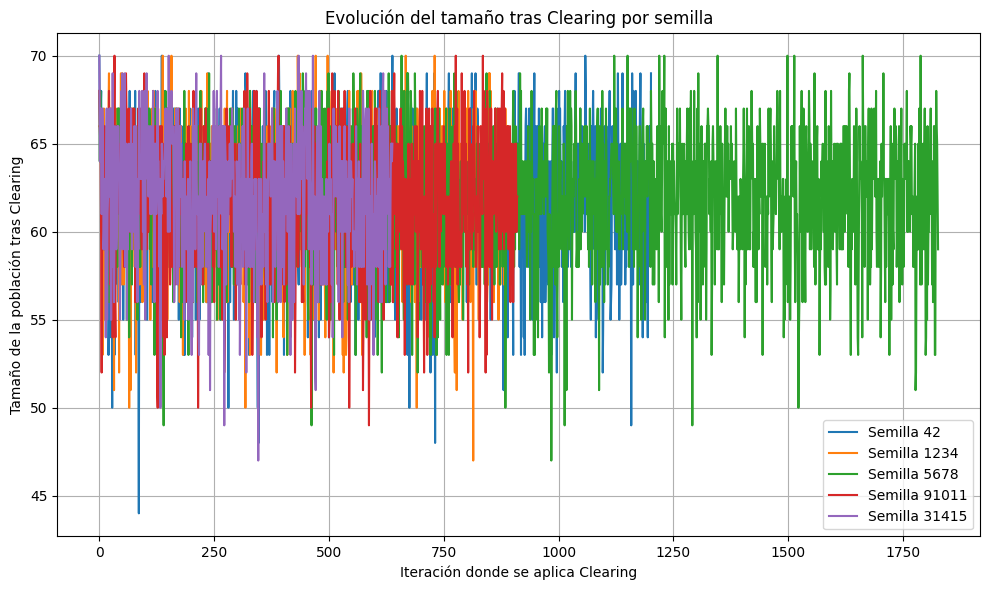

Ejecución 42: Mejor costo encontrado = 124004, Evaluaciones = 276745
Ejecución 1234: Mejor costo encontrado = 123404, Evaluaciones = 456693
Ejecución 5678: Mejor costo encontrado = 125000, Evaluaciones = 276857
Ejecución 91011: Mejor costo encontrado = 124156, Evaluaciones = 349367
Ejecución 31415: Mejor costo encontrado = 124340, Evaluaciones = 265827

Resumen del experimento:
Mejor coste: 123404
Media: 124180.80
Desviación típica: 516.09
Varianza: 266344.96
Error Relativo (RE): 0.63%
Coeficiente de Variación (CV): 0.42%


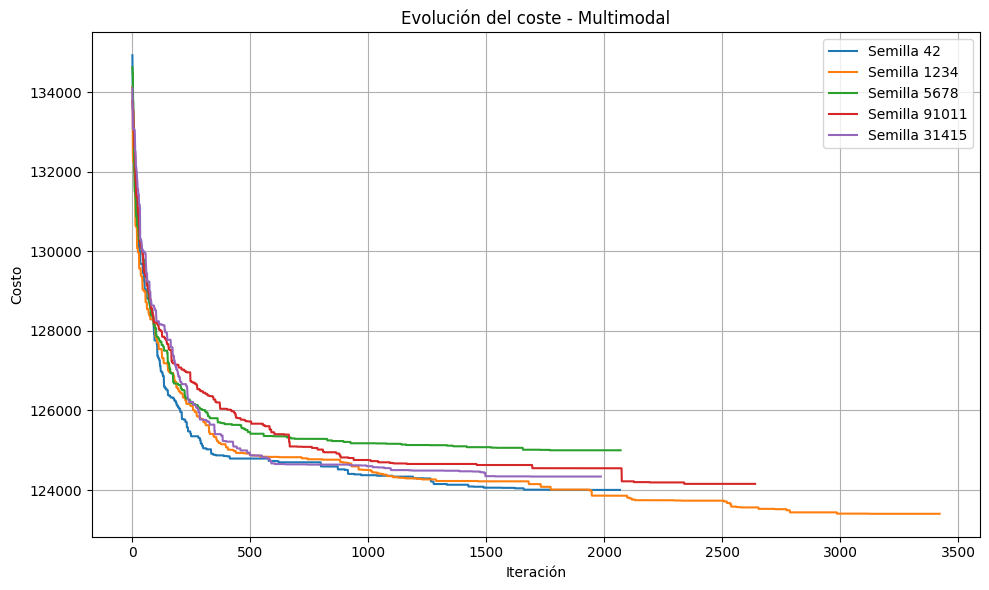

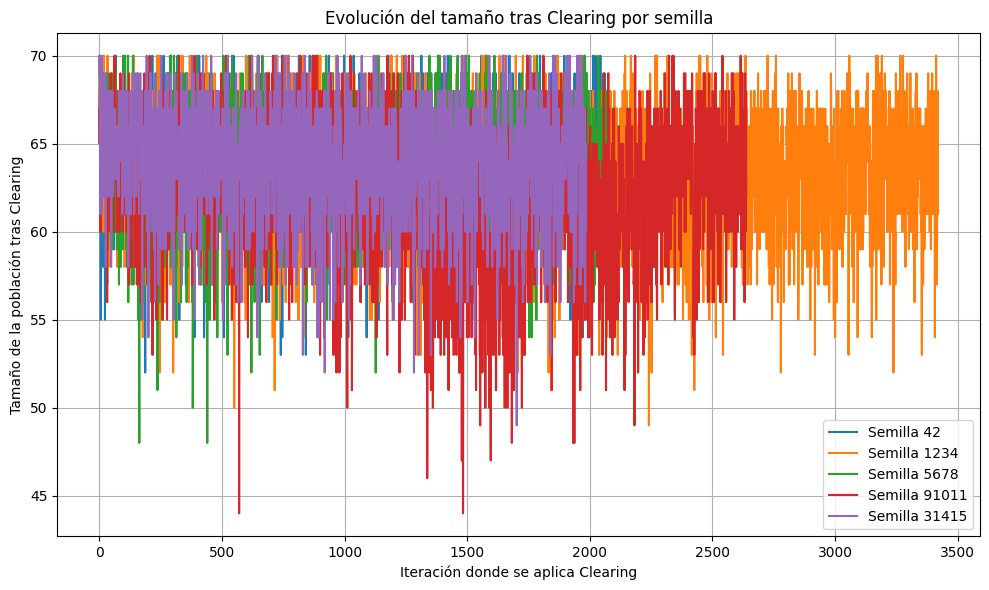

Ejecución 42: Mejor costo encontrado = 574465422, Evaluaciones = 871102
Ejecución 1234: Mejor costo encontrado = 580396757, Evaluaciones = 700164
Ejecución 5678: Mejor costo encontrado = 571755607, Evaluaciones = 1190387
Ejecución 91011: Mejor costo encontrado = 566320983, Evaluaciones = 1174705
Ejecución 31415: Mejor costo encontrado = 566444990, Evaluaciones = 1535324

Resumen del experimento:
Mejor coste: 566320983
Media: 571876751.80
Desviación típica: 5285394.62
Varianza: 27935396257190.96
Error Relativo (RE): 0.98%
Coeficiente de Variación (CV): 0.92%


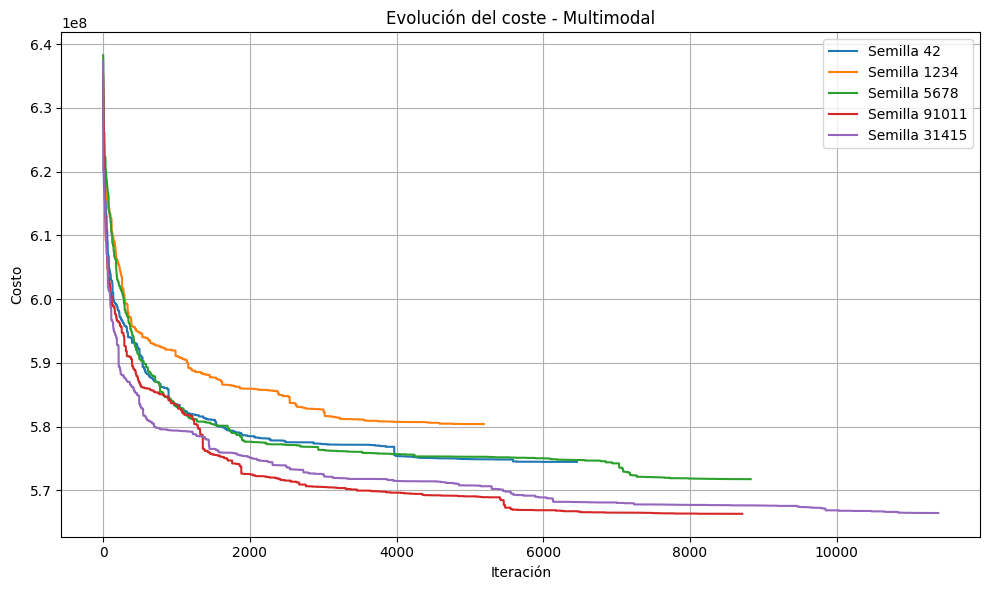

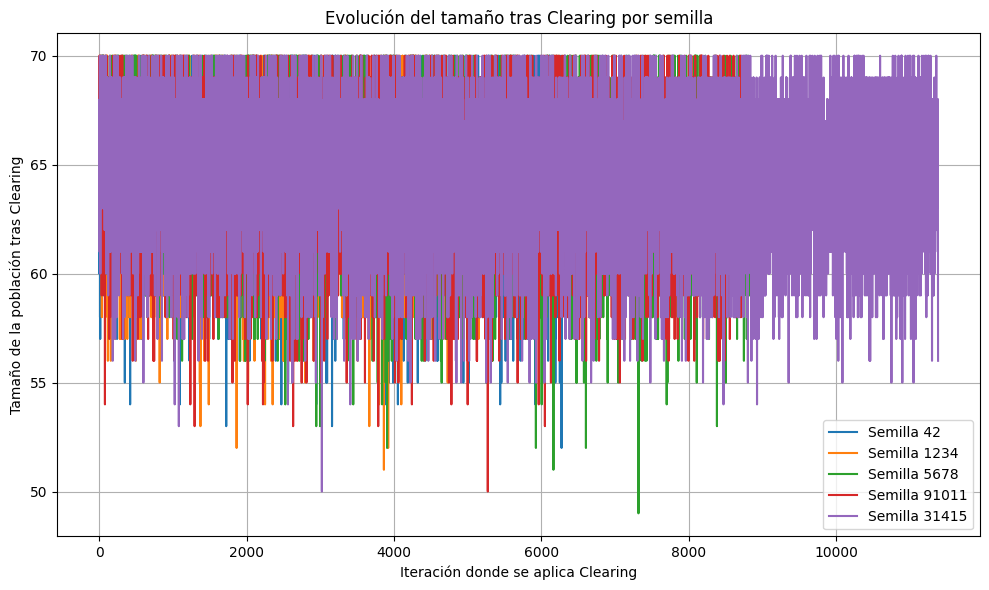

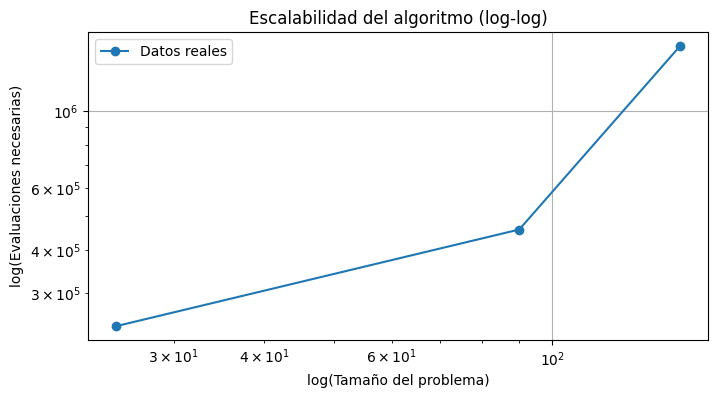

Pendiente (β) = 0.9300
Intercepto (α) = 4.0289


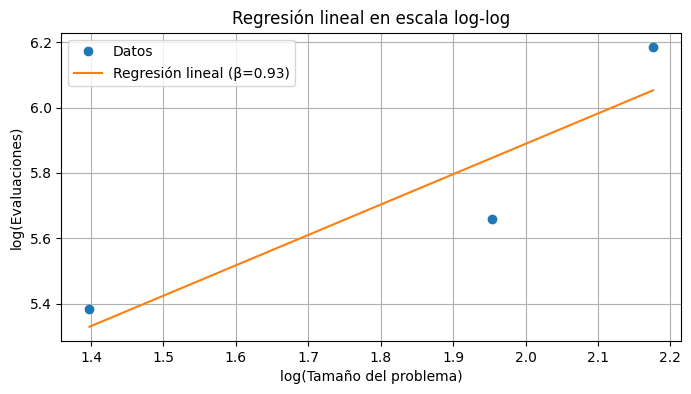

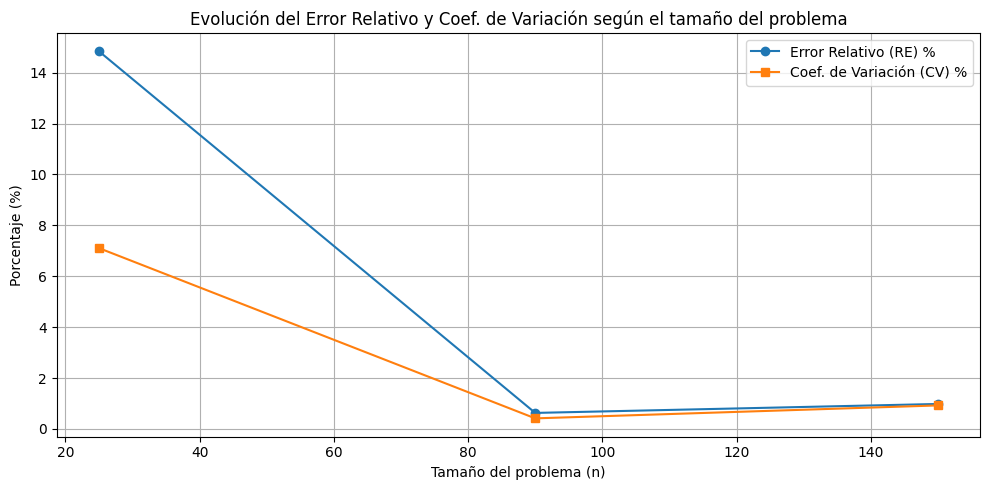

In [ ]:
b1, e1, h1 = ejecutarExperimentoMultimodal('/content/drive/MyDrive/Datos/tai25b.dat', seeds)
b2, e2, h2 = ejecutarExperimentoMultimodal('/content/drive/MyDrive/Datos/sko90.dat', seeds)
b3, e3, h3 = ejecutarExperimentoMultimodal('/content/drive/MyDrive/Datos/tai150b.dat', seeds)
tamaños = np.array([25, 90,150])
# Número de evaluaciones necesarias (ejemplo ficticio)
evaluaciones =[]
evaluaciones.append( max(e1))
evaluaciones.append( max(e2))
evaluaciones.append( max(e3))
# Gráfica log-log
plt.figure(figsize=(8, 4))
plt.loglog(tamaños, evaluaciones, 'o-', label='Datos reales')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones necesarias)')
plt.title('Escalabilidad del algoritmo (log-log)')
plt.grid(True)
plt.legend()
plt.show()

log_sizes = np.log10(tamaños)
log_evals = np.log10(evaluaciones)

# Regresión lineal en escala log-log
slope, intercept = np.polyfit(log_sizes, log_evals, 1)
print(f"Pendiente (β) = {slope:.4f}")
print(f"Intercepto (α) = {intercept:.4f}")

# Para graficar la recta ajustada
x_fit = np.linspace(min(log_sizes), max(log_sizes), 100)
y_fit = slope * x_fit + intercept

# Gráfica log-log
plt.figure(figsize=(8, 4))
plt.plot(log_sizes, log_evals, 'o', label='Datos')
plt.plot(x_fit, y_fit, '-', label=f'Regresión lineal (β={slope:.2f})')
plt.xlabel('log(Tamaño del problema)')
plt.ylabel('log(Evaluaciones)')
plt.title('Regresión lineal en escala log-log')
plt.legend()
plt.grid(True)
plt.show()

mejores = np.array([min(b1), min(b2), min(b3)])
medias = np.array([np.mean(b1), np.mean(b2), np.mean(b3)])
stds = np.array([np.std(b1), np.std(b2), np.std(b3)])

# Cálculo de métricas
error_relativo = (medias - mejores) / mejores  # como proporción
cv = stds / medias  # como proporción

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(tamaños, error_relativo * 100, 'o-', label='Error Relativo (RE) %')
plt.plot(tamaños, cv * 100, 's-', label='Coef. de Variación (CV) %')
plt.xlabel('Tamaño del problema (n)')
plt.ylabel('Porcentaje (%)')
plt.title('Evolución del Error Relativo y Coef. de Variación según el tamaño del problema')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()